# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment
Install spp client to your local device: pip install -i https://pip.s2.allenai.org/simple spp_client

## 1. Get annotation store data

### 1a. Get source names and endpoint types
Retreive information about the sources for each annotation - mentions, bib-entries, bib-entry-parses, and pdf plumber

In [1]:
#Temporary, will change with each paper
mention_detection_source = "citation_mentions-0.0.0|pdfplumber-0.0.5"
bib_mention_linker_source = "citation-links-0.0.0|citation_mentions-0.0.0|pdfplumber-0.0.5"
bib_detection_source = "bib-entry-detector-0.0.test|vila-0.0.2|pdfplumber-0.0.5"
pdf_plumber= "pdfplumber-0.0.5"
bib_parsing_source= "bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5"

### 1b. Retrieve Annotations for tokens, rows, and pages
Using the sources obtained from the previous cell, we will now retreive the annotations for each source depending on if they are in the annotation store as a PDF or plain text.

In [2]:
# !!!! ANNOTATOR TODO: Update with your path (if layoutparser package not working)
import sys
sys.path.append("/Users/baileyk/opt/anaconda3/envs/mmda/lib/python3.8/site-packages/") # get layoutparser path
import layoutparser 

In [3]:
# Get annotations using chrisW's spp client
from spp_client.client import DocumentAnnotations, SppClient

# !!!! ANNOTATOR TODO: change this to sha you're analzying
#sha = '17ada3c96ef888fc89f6b995d2edd19a45383423'
sha = '121e30c48546e671dc5e16c694c5e69b392cf8fb'

client = SppClient.mk(env="dev")
plumber_version = "pdfplumber-0.0.5"


lp = "layout-parser-0.0.2|pdfplumber-0.0.5"

doc_annos = [
    DocumentAnnotations(
        source=lp,
        annotation_type="blocks"
    ),
    
    DocumentAnnotations(
        source="vila-0.0.2|layout-parser-0.0.2|pdfplumber-0.0.5",
        annotation_type="vila_span_groups"
    ),
    
    DocumentAnnotations(
        source="citation_mentions-0.0.0|pdfplumber-0.0.5",
        annotation_type="citation_mentions"
    ),
    
    DocumentAnnotations(
        source="bib-entry-detector-0.0.test|vila-0.0.2|pdfplumber-0.0.5",
        annotation_type="bib_entries"
    ),
    
    DocumentAnnotations(
    bib_entry_titles
]

mmda_doc = client.get_mmda_doc(
    sha,
    plumber_version,
    doc_annos,
    include_images=True
)

### 1c. Check to make sure you have annotated all fields onto mmda doc
Should be: 'tokens', 'pages', 'rows', 'blocks', 'vila_span_groups', 'citation_mentions', 'bib_entries'

In [4]:
print(mmda_doc.fields)
#print(mmda_doc.images[16])
print()
#print(mmda_doc.citation_mentions[0])

['tokens', 'pages', 'rows', 'blocks', 'vila_span_groups', 'citation_mentions', 'bib_entries']



## 2. Visalize Paper and Draw boxes on mentions
Use draw boxes to visualize each mention

### 2a. Get Random page to annotate

In [19]:
# !!!! ANNOTATOR TODO: Record page # from output in annotation spreadsheet
# get random page number to review and annotate

import random # to get random page number to annotate
#annot_page = random.randrange(1,len(mmda_doc.pages)) 
#print("page to annotate:", annot_page)

#temp override
annot_page = 1

#s3://ai2-s2-mmda/citation-link-evaluation-sample/

FileNotFoundError: [Errno 2] No such file or directory: '17ada3c96ef888fc89f6b995d2edd19a45383423.json'

### 2b. Make boxgroups for mentions so that boxes can be drawn for them.

In [18]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(mmda_doc):

    result_boxes_list = defaultdict(list)
    dictionary_of_boxes = defaultdict(list)
    
    for cite in mmda_doc.citation_mentions:
        for span in cite.spans:
            dictionary_of_boxes[span.box.page].append(span.box) 
    
    #mapping between pages and spans on page
    for page, list_of_boxes in dictionary_of_boxes.items():
        page_w, page_h = mmda_doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_list[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_list


#function to create box groups from grobid data on the mmda doc
def make_boxgroup_mentions_from_grobid(grobid_annotation):
    result_boxes_list = defaultdict(list)
    for mention in grobid_annotation["refMarkers"]:
        page = mention["p"]
        box = lpe.Rectangle(
            mention["x"], 
            mention["y"], 
            mention["x"] + mention["w"],
            mention["y"] + mention["h"]
        )
        result_boxes_list[page].append(box)
    return result_boxes_list

### 2c. Draw boxes given box groups.

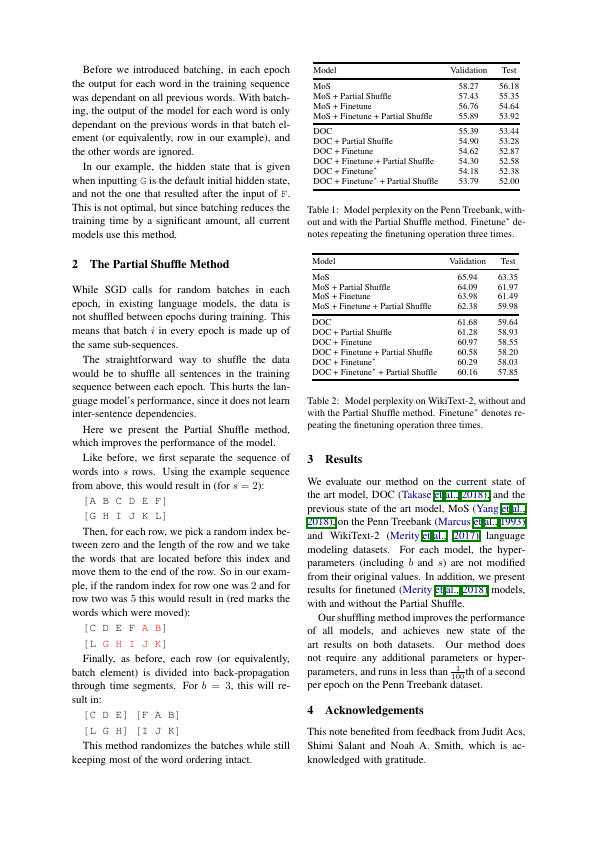

In [7]:
#egor version
def draw_boxgroups(image, rectangle_list, color_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'green', 'color_2': 'blue', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle, type=f'color_1')) #add id group here
        
    if image:
        return lpv.draw_box(image, viz, color_map=color_map, show_element_id=False)
    
    return None

#make boxes
dic_boxgroups = make_boxgroups_mentions(mmda_doc)
boxgroups = make_boxgroup_mentions_from_grobid(grobid_annotation)

#this would display all pages of the pdf
"""for page in range(len(mmda_doc.images)):
    #draw boxes on the doc at each page in rectangle_list
    image = draw_boxgroups(mmda_doc.images[page], list(dictionary_of_boxes[page]))
    display(image)"""

#sp+
image = draw_boxgroups(mmda_doc.images[1], list(dic_boxgroups[1]))

image = draw_boxgroups(mmda_doc.images[annot_page], list(boxgroups[annot_page+1]))

display(image)

## 3. Get references and s2 id's for each mention.

### 3a. Load data from annotations API.

In [8]:
import urllib.request, json 

# !!!! ANNOTATOR TODO: Add text id
#sha = '121e30c48546e671dc5e16c694c5e69b392cf8f'
doc_id = 'db5a7b32b7436cdc0827728305f2f228f6c90666'

# get data from json file, plain-text
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/plain-text/{doc_id}/annotations?"
                            f"annotationSources=all&attributeSources=all") as url:
    data = json.load(url)

mention_detection_source= "citation_mentions-0.0.0|pdfplumber-0.0.5"

### 3b. Retreive citation mention numbers and which bib entries they are linked to.

In [9]:
#for citation_mention '0', the bib_entry_id it's linked to is '3'. 
#set key value to bib entry id
citation_links = defaultdict(int)

for i in data['annotationsFromSource'][f'{mention_detection_source}']['citation_mentions']:
    citation_mention_id = i['attributesFromSource']['citation_mentions-0.0.0|pdfplumber-0.0.5']['id']
    linked_bib_id = i['attributesFromSource']['citation-links-0.0.0|citation_mentions-0.0.0|pdfplumber-0.0.5']['bib_entry_id']
    citation_links[citation_mention_id] = int(linked_bib_id)

print(citation_links)

defaultdict(<class 'int'>, {0: 3, 1: 3, 2: 0, 3: 2, 4: 3})


In [179]:
#bib entry titles
bib_ent_titles = []
for i in data['annotationsFromSource'][f'{bib_detection_source}']['bib_entries']:
    bib_ent_titles.append(i['attributesFromSource'][f'{bib_detection_source}']['text'])

#print(mmda_doc.bib_entries[0].metadata.text)

In [17]:
for i in data['annotationsFromSource']['bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5']['bib_entry_titles']:
    print(i)


{'id': 'bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5/bib_entry_titles/0', 'startChar': 7223, 'endChar': 7286, 'attributesFromSource': {'bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5': {'text': '', '_group': 0}}}
{'id': 'bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5/bib_entry_titles/1', 'startChar': 7388, 'endChar': 7436, 'attributesFromSource': {'bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5': {'text': '', '_group': 1}}}
{'id': 'bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5/bib_entry_titles/2', 'startChar': 7571, 'endChar': 7602, 'attributesFromSource': {'bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5': {'text': '', '_group': 2}}}
{'id': 'bib_entry_predictor-0.0.test|bib-entry-detector-0.0.test|pdfplumber-0.0.5/bib_entry_titles/3', 'startChar': 7712, 'endChar': 7767, 'attributesFromSource': {'bib_entry_predictor-0.0.test

In [188]:
#gives table of mentions, 

pd.DataFrame({
    "Mention #": [mention for mention in citation_links],
    "Bib Entry Title": [title for title in bib_ent_titles],
    "Linked Bib id": [bib_id for bib_id in citation_links.values()]
    },
    pd.set_option('max_colwidth', 100)
)

#example
#{0: 3, 1: 3, 2: 0, 3: 2, 4: 3}

#for citation_mention '0', the bib_entry_id it's linked to is '3'. If we go down to bib entry id 3, 
#it's "Sho Takase...", which IS citation mention 0 (first citation) on this page :-)

,Mention #,Bib Entry Title,Linked Bib id
0,0,"Mitchell\nP.\nMarcus,\nBeatrice\nSantorini,\nand\nMary\nAnn\nMarcinkiewicz.\n1993.\nBuilding a l...",3
1,1,"Stephen\nMerity,\nNitish\nShirish\nKeskar,\nand\nRichard\nSocher.\n2018.\nRegularizing and optim...",3
2,2,"Stephen\nMerity,\nCaiming\nXiong,\nJames\nBradbury,\nand\nRichard\nSocher.\n2017.\nPointer senti...",0
3,3,"Sho Takase, Jun Suzuki, and Masaaki Nagata. 2018.\nDirect output connection for a high-rank lang...",2
4,4,"Zhilin\nYang,\nZihang\nDai,\nRuslan\nSalakhut-\ndinov,\nand\nWilliam\nW.\nCohen.\n2018.\nBreakin...",3


### Use API call to find what s2 paper each bib entry is linked to.

In [162]:
print(bib_ent_titles)

import os
import requests
import json
def bibLinkingApiPost(titles, end_points):
    payload = json.dumps([{'title': title} for title in bib_ent_titles])
    headers = {
        'Content-Type': 'application/json'
    }
    
    response = requests.request("POST", end_points, headers=headers, data=payload).json()
    return response

"""{
"title": "string",
}"""

test = bibLinkingApiPost(bib_ent_titles, 'http://pipeline-api.prod.s2.allenai.org/citation/match' )
print()
print(test)

['Mitchell\nP.\nMarcus,\nBeatrice\nSantorini,\nand\nMary\nAnn\nMarcinkiewicz.\n1993.\nBuilding a large annotated corpus of english: The penn treebank.\nComputational Linguistics , 19(2).', 'Stephen\nMerity,\nNitish\nShirish\nKeskar,\nand\nRichard\nSocher.\n2018.\nRegularizing and optimizing LSTM language models.\nIn International Conference on Learning Represen-\ntations .', 'Stephen\nMerity,\nCaiming\nXiong,\nJames\nBradbury,\nand\nRichard\nSocher.\n2017.\nPointer sentinel mixture models.\nIn International\nConference on Learning Representations .', 'Sho Takase, Jun Suzuki, and Masaaki Nagata. 2018.\nDirect output connection for a high-rank language model.\nIn Proceedings of the 2018 Conference on Empir-\nical Methods in Natural Language Processing ,\npages 4599–4609. Association for Computational\nLinguistics.', 'Zhilin\nYang,\nZihang\nDai,\nRuslan\nSalakhut-\ndinov,\nand\nWilliam\nW.\nCohen.\n2018.\nBreaking the softmax bottleneck: A high-rank RNN language model.\nIn International C